In [2]:
import pandas as pd
import numpy as np
from haversine import haversine, haversine_vector, Unit
import geopandas as gpd
import matplotlib.pyplot as plt
import cma

In [3]:
# To supress the scientific notation for easier reading.
np.set_printoptions(suppress=True)

# Test Development

In developing the code, three main tests have been completed within one region: Amhara. The first at a very micro level with a custom dummy dataset with only two primary schools and 2 proposed secondary schools. The second is for one woreda/district with 21 primary schools and two secondary schools, whereby 5 secondary schools are proposed. The final test was a region wide test with 1765 primary schools and 1658 secondary schools, with 5 new secondary schools proposed.

In [4]:
# Specify which test to perform
declare_test = 2 # micro test

In [5]:
# Declare key variables according to the test being performed.
region = 'Amhara' # Test Amhara region
woreda = 'ET030908'

if declare_test == 1: # for micro test
    # read in the prepared dataset. Evaluate point data to make it readible by geopandas
    df = pd.read_csv('data/test_dataset2.csv', converters={'point': pd.eval})
    proposed_schools= 2
    gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
elif declare_test == 2:
    df = pd.read_csv('data/test_dataset.csv', converters={'point': pd.eval})
    proposed_schools= 5
    gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
else:
    proposed_schools= 5
    df = pd.read_csv('data/clean_dataset.csv', converters={'point': pd.eval})
    # limit geojson to only selected region
    # limit clean dataset to only selected region
    gdf_region = gpd.read_file('eth_shape_files/json//eth_admin1v2.json') # read in geojson
    gdf_region_shp = gdf_region.loc[gdf_region['ADM1_EN']==region]['geometry'].reset_index(drop=True)
    df = df.loc[df['region'] == region]
    bounds = gdf_region_shp.bounds 

## Data Preparation

In [6]:
# Establish boundaries based on the bounds of region or woreda.
# Latitude is the Y axis, longitude is the X axis.

lat_bounds = bounds[['miny','maxy']].to_numpy(dtype=float)[0]
lon_bounds = bounds[['minx','maxx']].to_numpy(dtype=float)[0]
bounds = np.array([[lat_bounds[0], lon_bounds[0]], [lat_bounds[1], lon_bounds[1]]])
# array - [[lower lat bounds, lower lon bounds],[upper lat bounds, upper lon bounds]]
# CMA expects a list of size 2 for bounds
x1y1 = np.repeat([bounds[0,:]],proposed_schools, axis=0).flatten()
x2y2 = np.repeat([bounds[1,:]],proposed_schools, axis=0).flatten()
boundsxy = np.array([x1y1,x2y2])
boundsxy

array([[10.71371939, 36.68932805, 10.71371939, 36.68932805, 10.71371939,
        36.68932805, 10.71371939, 36.68932805, 10.71371939, 36.68932805],
       [10.96477258, 36.96973029, 10.96477258, 36.96973029, 10.96477258,
        36.96973029, 10.96477258, 36.96973029, 10.96477258, 36.96973029]])

In [7]:
# Create subset arrays required as input for enrollment function.
# 1. Primary school enrollment data
# 2. Primary school location data: lat lon point data. 
# 3. Secondary schoool location data: lat lon point data. 
# 4. Secondary school enrollment data. Potentially required for calibration function.

df_prim = df.loc[ (df['gr_offer'] == 'G.1-8') | (df['gr_offer'] == 'G.5-8')]
df_prim_enroll = df_prim['grade5_8'].reset_index(drop=True).to_numpy(dtype=float)
df_prim_loc = df_prim['point'].reset_index(drop=True).to_numpy()
df_prim_loc = np.array([np.array(i) for i in df_prim_loc], dtype=float)

df_sec = df.loc[ (df['gr_offer'] == 'G. 9-10') | (df['gr_offer'] == 'G. 9-12')]
df_sec_loc = df_sec['point'].reset_index(drop=True).to_numpy()
df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy(dtype=float)
df_sec_loc = np.array([np.array(i) for i in df_sec_loc], dtype=float)

In [8]:
total_sec = len(df_sec_enroll)+ proposed_schools
total_sec

7

## Key functions

In [9]:
def check_woreda(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_woreda_shp[0]).all()
            
def check_region(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_region_shp[0]).all()

In [10]:
def shape(distance, enrollment):
    min_walk = 2 # distance not a factor issuing enrollment until 2km
    max_walk = 5 # distance greater than 5km assumes zero enrollment
    answer = np.where(distance<min_walk, enrollment,
             np.where(distance>max_walk, 0,
                     enrollment*(1-(distance-min_walk)/(max_walk-min_walk)))
            )
    return answer

In [11]:
def expected_enroll(prim_loc, x, prim_enroll):
    distance = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True)
    min_d = np.min(distance, axis=0) # array with minimum distance from each primacy school to every secondary.
    shaped_enroll = shape(min_d, prim_enroll)
    return np.sum(shaped_enroll)

In [12]:
# The Objective Function with the shape function included.
def f(x):
    x = np.append(df_sec_loc, x).reshape(total_sec,2) #  add new schools to existing and reshape
    test_case = expected_enroll(df_prim_loc, x, df_prim_enroll)
    return test_case

In [13]:
# Create random points within regional or district boundaries boundaries.

def create_random_sp(sp_type):
    if sp_type == 'region':
        shape_file = gdf_region_shp[0]
    else:
        shape_file = gdf_woreda_shp[0]
    sp_in_bounds = False
    while sp_in_bounds == False:
        sp1 = np.random.uniform(low=lat_bounds[0], high=lat_bounds[1], size=proposed_schools)
        sp2 = np.random.uniform(low=lon_bounds[0], high=lon_bounds[1], size=proposed_schools)
        sp = np.vstack((sp1, sp2)).T
        sp_points = gpd.points_from_xy(sp[:, 1], sp[:, 0])
        if sp_points.within(shape_file).all():
            sp_in_bounds = True
            return sp.flatten()

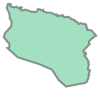

In [14]:
gdf_woreda_shp[0]

## Random Search

In [16]:
def random_search(f, n, test_type):
    x = [create_random_sp(test_type) for _ in range(n)] 
    fx = [(f(xi), xi) for xi in x]
    best_f, best_solution = max(fx, key=lambda x:x[0])
    return best_f, best_solution

In [ ]:
# %time fx = [random_search(f, 1000, 'woreda') for _ in range(4)]

In [180]:
x = create_random_sp('woreda')
x

array([10.82136049, 36.91335046, 10.80214043, 36.93284645, 10.9315821 ,
       36.70705843, 10.88440999, 36.72025325, 10.93727169, 36.78561278])

In [181]:
EEI = 0
current_ss_distance = df_prim['nearest_lwr_sec'].to_numpy()
current_ss_distance

array([6.4200536 , 0.97208858, 4.32832206, 5.29183205, 9.11916044,
       5.27713026, 1.73032317, 3.33592388, 5.22039308, 9.74686057,
       4.88778134, 4.00496738, 0.756862  , 7.40811787, 4.05068789,
       7.28259465, 9.52187629, 4.88278866, 5.29026977, 4.59711784,
       2.82367034])

In [182]:
new_ss_distance = haversine_vector(df_prim_loc, x, Unit.KILOMETERS, comb=True)[0]
new_ss_distance

array([ 5.64116004, 15.11721406,  6.13436507, 10.02368305,  8.83984667,
       11.32751955,  4.13699326, 22.70962695,  7.97068975, 18.52345868,
       10.15517587,  8.3067422 ,  3.70385326,  4.35940706, 20.71668678,
        3.59002845,  9.06262463, 12.3966341 ,  1.11650781, 16.99933686,
       13.40370134])

In [183]:
less_than5 = np.where(new_ss_distance < 5)
less_than5

(array([ 6, 12, 13, 15, 18], dtype=int64),)

In [184]:
new_ss_i = np.where(new_ss_distance[less_than5] < current_ss_distance[less_than5])
new_ss_i

(array([2, 3, 4], dtype=int64),)

In [192]:
new_ss_i


new_ss_distance[less_than5] < current_ss_distance[less_than5]

array([False, False,  True,  True,  True])

In [189]:
new_ss_distance < 

array([ 5.64116004, 15.11721406,  6.13436507, 10.02368305,  8.83984667,
       11.32751955,  4.13699326, 22.70962695,  7.97068975, 18.52345868,
       10.15517587,  8.3067422 ,  3.70385326,  4.35940706, 20.71668678,
        3.59002845,  9.06262463, 12.3966341 ,  1.11650781, 16.99933686,
       13.40370134])

In [188]:
shape(new_ss_distance[new_ss_i], df_prim_enroll[new_ss_i])

array([0., 0., 0.])

In [185]:
EEI += np.sum(shape(new_ss_distance[new_ss_i], df_prim_enroll[new_ss_i]))

In [186]:
EEI

0.0